In [1]:
import json
import pandas as pd
import numpy as np
import re

file_dir = "C:/Users/brian/Desktop/OSU Class/8/Movies-ETL/"


In [2]:
with open(f'{file_dir}wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)


In [3]:
len(wiki_movies_raw)


7311

In [4]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

In [5]:
#wiki_movies_df.head()

In [6]:
#wiki_movies_df.columns.to_list()

In [7]:
wiki_movies = [movie for movie in wiki_movies_raw
                if ('Director' in movie or 'Directed by' in movie)
                    and 'imdb_link' in movie
                    and 'No. of episodes' not in movie]

In [8]:
wiki_df = pd.DataFrame(wiki_movies)

In [9]:
#wiki_df.head()

In [10]:
#wiki_movies_df[wiki_movies_df['Based on'].notnull()]['Based on']
#wiki_movies_df[wiki_movies_df['Director'].notnull()]['Director']
#wiki_movies_df[wiki_movies_df['Language'].notnull()]['Language']
#wiki_movies_df[wiki_movies_df['Traditional'].notnull()]['Traditional']

In [11]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hewbrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
    
    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
            
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')            
    
    return movie

In [12]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
#sorted(clean_movies_df.columns.to_list())

In [13]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
#print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
#print(len(wiki_movies_df))
#wiki_movies_df.head()

In [14]:
# display each column and how many null are preset
#[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

In [15]:
# neat : drop column with 90% or more empty values
#[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

In [16]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [17]:
#wiki_movies_df.info()
#wiki_movies_df.head()

In [18]:
#wiki_movies_df['Box office'].isnull().sum()  #1548
#wiki_movies_df['Box office'].notnull().sum()  #5485

In [19]:
box_office = wiki_movies_df['Box office'].dropna()

In [20]:


def is_not_a_string(x):
    return type(x) != str

#box_office[box_office.map(is_not_a_string)]

In [21]:
#box_office[box_office.map(lambda x: type(x) != str)]

In [22]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
#box_office 

In [23]:
#reset notebook here and commented out test outputs

form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
#box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()
#"$123.4 million/billion."

In [24]:
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi?on)'
#box_office.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()
#"$123,456,789."

In [25]:
#matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
#matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)
#box_office[~matches_form_one & ~matches_form_two]

In [26]:
#box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [27]:
#box_office.str.extract(f'({form_one}|{form_two})')

In [28]:
def parse_dollars(s):
    #if s is not a string, return NaN
    if type(s) != str:
        return np.nan
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):
        
        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        
        # convert to float and multiply by a million
        value = float(s) * 10**6
        
        #return value
        return value
    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):
        
        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        
        # convert to float and multiply by a billion
        value = float(s) * 10**9
        
        #return value
        return value
    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illi?on)', s, flags=re.IGNORECASE):
        
        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)
                   
        # return value
        return value
    else:
        return np.nan

In [29]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [30]:
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [31]:
#reset notebook here and commented out test outputs

In [32]:
#wiki_movies_df['box_office']

In [33]:
#Create a budget varialbe
budget = wiki_movies_df['Budget'].dropna()

In [34]:
#Convert any list to strings
budget = budget.map(lambda x: ''.join(x) if type(x) == list else x)

In [35]:
#remove any values between a dollar sign and a hyphen (for budgets given in ranges)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [36]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget = budget.str.replace(r'\[\d+\]\s*', '', regex=True)
#budget[~matches_form_one & ~matches_form_two]

In [37]:
#parse the budget data
wiki_movies_df['Budget'] = \
                    budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [38]:
#reset notebook here and commented out test outputs

In [39]:
#Parse Release Data
#Create variable that hold non-null values of Release date in the dataframe converting lists to strings
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

#Full month name, one- to two-digit day, four-digit year (i.e., January 1, 2000)
#Mine <<<<<<<Month<<<<<\d{1,2}[\W\S]\d{4}
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'

#Four-digit year, two-digit month, two-digit day, with any separator (i.e., 2000-01-01)
#Mine \d{4}[\W\S]\d{2}[\W\S]\d{2}[\W\S]
date_form_two = r'\d{4}.[01]\d.[0123]\d'

#Full month name, four-digit year (i.e., January 2000)
#Mine <<<<<<<Month<<<<<\d{4}
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'

#Four-digit year
#Mine 
date_form_four = r'\d{4}'

release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)


In [40]:
#Parse Running Time
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ''.join(x) if type(x) == list else x)

In [49]:
# 6528 / 6894
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                      UK:84 min (DVD version)US:86 min
727                         78-102 min (depending on cut)
840                           Varies (79[3]–84[1]minutes)
1347                                                25:03
1443    United States:77 minutesArgentina:94 minutesGe...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version:86 minutesOriginal version...
4967     Theatrical cut:97 minutesUnrated cut:107 minutes
5424                          115[1]/123[2]/128[3]minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [66]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 +row[1] if row[2] == 0 else row[2], axis=1)
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [ ]:
# First 5 records
#wiki_movies_raw[:5]

In [ ]:
# Last 5 records
#wiki_movies_raw[-5:]

In [ ]:
# Some records in the middle
#wiki_movies_raw[3500:3605]

In [67]:
kaggle_metadata = pd.read_csv(f'{file_dir}archive/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}archive/ratings.csv')

In [89]:
#kaggle_metadata.dtypes

belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                       bool
vote_average             float64
vote_count               float64
dtype: object

In [83]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [88]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [90]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)

In [92]:
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')

In [93]:
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [94]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [95]:
ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


C:\Users\brian\.conda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [99]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

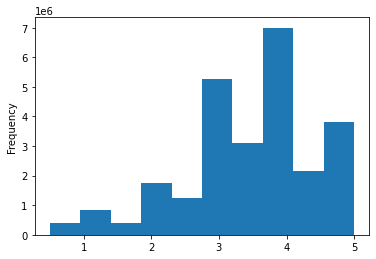

In [100]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [ ]:
kaggle_metadata.sample(n=5)

In [ ]:
wiki_movies_raw